In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Strategy():
    def __init__(self):
        self.equity = 0
        self.position = 0
        
    def signal(self):
        pass

In [81]:
class TakeProfitStrategy(Strategy):
    def __init__(
        self,
        buy_level,
        take_profit,
        stop_loss,
        trailing=True
    ):
        super().__init__()
        self.buy_level = buy_level
        self._take_profit = take_profit
        self._stop_loss = stop_loss
        self.trailing = trailing
        
        self.max_price = None
        self.buy_price = None
        self.position = 0
        
    def buy_signal(self, current_price, prev_price):
        if (
            prev_price > self.buy_level and
            current_price < self.buy_level
        ) or (
            prev_price < self.buy_level and
            current_price > self.buy_level
        ):
            return True
        else:
            return False
        
    def take_profit(self, current_price):
        if current_price > self._take_profit:
            return True
        else:
            return False
        
    def stop_loss(self, current_price):
        if self.trailing:
            reference_price = self.max_price
        else:
            reference_price = self.buy_price
            
        if current_price <= reference_price - self._stop_loss:
            return True
        else:
            return False
    
    def open_trade(self, current_price):
        self.position = 1
        self.buy_price = current_price
        self.max_price = current_price
    
    def update_max(self, current_price):
        if current_price > self.max_price:
            self.max_price = current_price
    
    def close_trade(self, current_price):
        self.position = 0
        self.equity += current_price - self.buy_price
    
    def signal(self, current_price, prev_price):
        if (
            self.position == 0 and
            self.buy_signal(current_price, prev_price)
        ):
            print('Buy signal: price level %s crossed' % self.buy_level)
            self.open_trade(current_price)
            
        elif self.position == 1:
            self.update_max(current_price)
            
            if self.take_profit(current_price):
                print('Sell signal: take profit level %s crossed' % 
                      self._take_profit)
                self.close_trade(current_price)
                
            elif self.stop_loss(current_price):
                print('Sell signal: stop loss activated at %s' %
                      round(current_price, 2))
                self.close_trade(current_price)
            else:
                pass

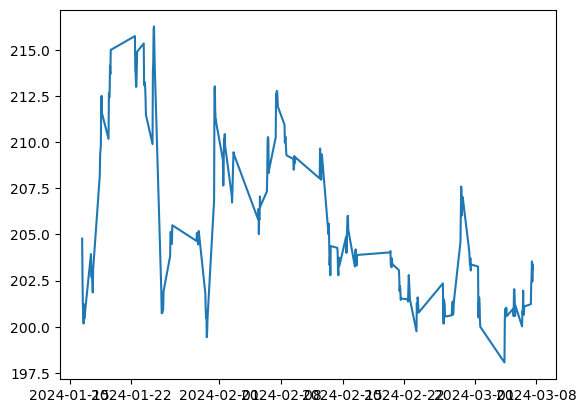

In [76]:
TICKER = 'BA'
START_DATE = '2024-01-16'
END_DATE = '2024-03-08'
INTERVAL = '1h'

BUY_LEVEL = 206
TAKE_PROFIT = 210
STOP_LOSS = 1

import yfinance as yf

ticker = yf.Ticker(TICKER)
ticker_data = ticker.history(
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL
)

ticker_data.head()

plt.plot(ticker_data['Close'])

In [80]:
print('Starting backtest...')

print('Creating strategy...')
strategy = TakeProfitStrategy(BUY_LEVEL, TAKE_PROFIT, STOP_LOSS)
equity_curve = np.zeros(len(ticker_data) - 1)

for i in range(len(ticker_data) - 1):
    current_price = ticker_data['Close'][i + 1]
    prev_price = ticker_data['Close'][i]
    print('Current price: ',
          round(current_price, 2))
    strategy.signal(current_price, prev_price)
    equity_curve[i] = strategy.equity
    
print('Done!')
print('Final equity: ', 
      round(strategy.equity, 2))

Starting backtest...
Creating strategy...
Current price:  202.6
Current price:  201.1
Current price:  200.76
Current price:  200.18
Current price:  201.22
Current price:  200.43
Current price:  203.94
Current price:  202.82
Current price:  202.67
Current price:  202.9
Current price:  202.42
Current price:  201.86
Current price:  203.11
Current price:  208.16
Buy signal: price level 206 crossed
Current price:  209.29
Current price:  209.57
Current price:  209.81
Current price:  211.99
Sell signal: take profit level 210 crossed
Current price:  212.51
Current price:  211.58
Current price:  210.18
Current price:  212.67
Current price:  212.41
Current price:  212.69
Current price:  214.15
Current price:  213.69
Current price:  215.0
Current price:  215.75
Current price:  213.9
Current price:  213.74
Current price:  213.0
Current price:  213.01
Current price:  213.97
Current price:  214.9
Current price:  215.35
Current price:  213.15
Current price:  213.07
Current price:  213.24
Current pric

/tmp/ipykernel_5804/22127489.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = ticker_data['Close'][i + 1]
/tmp/ipykernel_5804/22127489.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = ticker_data['Close'][i]


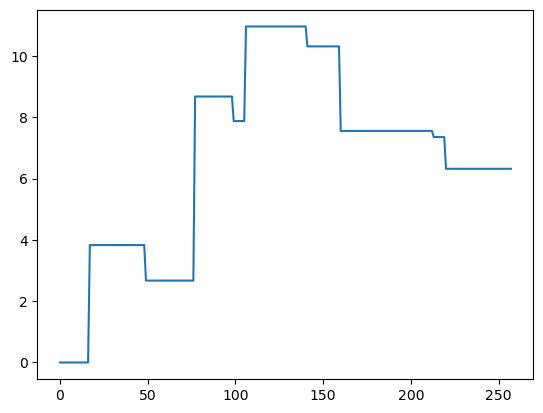

In [78]:
plt.plot(equity_curve)